In [1]:
import os; import sys ; import matplotlib as mpl ; import matplotlib.pyplot as plt ; import numpy as np
import pathlib; from pathlib import Path; import pandas as pd; import flopy

In [2]:
example_name = "MT3D_tutorial_03"
exe_name_mf = 'E:\\15_REPOS\\00_BETAMI\\bin\\mf2005'
exe_name_mt = 'E:\\15_REPOS\\00_BETAMI\\bin\\mt3d-usgs_1.1.0_64'
current_directory = os.getcwd();  print(current_directory)

E:\15_REPOS\00_BETAMI\98_Plus\02_MT3D


In [3]:
path = pathlib.Path('E:\\15_REPOS\\00_BETAMI\\98_Plus\\02_MT3D')
path.mkdir(parents=True, exist_ok=True); os.chdir(path); current_directory = os.getcwd()
directory_name = 'B_p03_V02c_Iacopo'    ; workspace = os.path.join('.', directory_name)
if os.path.isdir(workspace) is False:
    os.mkdir(workspace) 
output_folder = Path('B_p03_V02c_Iacopo') ; output_folder.mkdir(exist_ok=True)

In [4]:
def p03(dirname, mixelm):
    model_ws = os.path.join(workspace, dirname)
    nlay = 1  ; nrow = 31 ; ncol = 46  ; delr = 10  ; delc = 10  ; delv = 10  ; Lx = (ncol - 1) * delr ; v = 1.0 / 3.0; prsity = 0.3  
    q = v * prsity ; al = 10.0 ; trpt = 0.3 ; q0 = 1.0; c0 = 1000.0 ; perlen_mf = 365.0 ; perlen_mt = 365.0 ; hk = 1.0 ; laytyp = 0

    modelname_mf = dirname + "_mf"
    mf = flopy.modflow.Modflow     (modelname=modelname_mf, model_ws=model_ws, exe_name=exe_name_mf)
    dis = flopy.modflow.ModflowDis (mf,nlay=nlay,nrow=nrow,ncol=ncol,delr=delr,delc=delc,top=0.0,botm=[0 - delv],perlen=perlen_mf)
    
    ibound = np.ones((nlay, nrow, ncol), dtype=int)      ; ibound[0, :,  0] = -1  ; ibound[0, :, -1] = -1
    strt = np.zeros((nlay, nrow, ncol), dtype=float)     ; h1 = q * Lx            ; strt[0, :, 0] = h1
    bas = flopy.modflow.ModflowBas (mf, ibound=ibound, strt=strt)
    lpf = flopy.modflow.ModflowLpf (mf, hk=hk, laytyp=laytyp)
    wel = flopy.modflow.ModflowWel (mf, stress_period_data=[[0, 15, 15, q0]])
    pcg = flopy.modflow.ModflowPcg (mf)  
    oc = flopy.modflow.ModflowOc   (mf)     # *.hds
    lmt = flopy.modflow.ModflowLmt (mf)                         ; mf.write_input() ; mf.run_model(silent=True)

    modelname_mt = dirname + "_mt"
    mt = flopy.mt3d.Mt3dms   (modelname=modelname_mt,model_ws=model_ws,exe_name=exe_name_mt,modflowmodel=mf,)
    btn = flopy.mt3d.Mt3dBtn (mt, icbund=1, prsity=prsity, sconc=0)
    dceps = 1.0e-5 ; nplane = 1 ; npl = 0 ; nph = 16 ; npmin = 2 ; npmax = 32 ; dchmoc = 1.0e-3 ; nlsink = nplane ; npsink = nph
    adv = flopy.mt3d.Mt3dAdv (mt,mixelm=mixelm,dceps=dceps,nplane=nplane,npl=npl,nph=nph,npmin=npmin,npmax=npmax,nlsink=nlsink,npsink=npsink,percel=0.5)
    dsp = flopy.mt3d.Mt3dDsp (mt, al=al, trpt=trpt)             ; spd = {0: [0, 15, 15, c0, 2]}
    ssm = flopy.mt3d.Mt3dSsm (mt, stress_period_data=spd)
    gcg = flopy.mt3d.Mt3dGcg (mt)                               ; mt.write_input()
    
    fname = os.path.join (model_ws, "MT3D001.UCN")
    if os.path.isfile (fname):
        os.remove(fname)
    mt.run_model(silent=True)
    fname = os.path.join(model_ws, "MT3D001.UCN") ; ucnobj = flopy.utils.UcnFile(fname) ; times = ucnobj.get_times() ; conc = ucnobj.get_alldata()
   
    fname = os.path.join(model_ws, "MT3D001.OBS")
    if os.path.isfile(fname):
        cvt = mt.load_obs(fname)
    else:
        cvt = None
    fname = os.path.join(model_ws, "MT3D001.MAS")
    mvt = mt.load_mas(fname)
    return mf, mt, conc, cvt, mvt, times

Text(0.5, 1.0, '3 HMOC | -1 TVD | 365d')

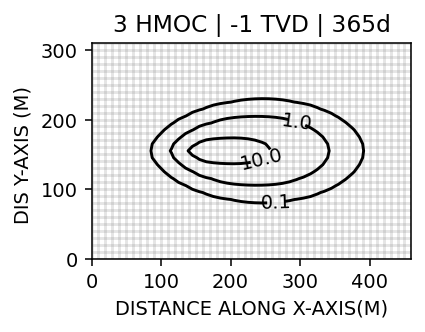

In [5]:
mf, mt, conc, cvt, mvt, times = p03("p03", 3)  # ________   mixelm = 3 ... -1 
conc = conc[0, :, :, :] ; plt.figure(figsize=(7, 2), dpi=140)
ax = plt.subplot(1, 1, 1, aspect="equal")    ; pmv = flopy.plot.PlotMapView(model=mf)  ; pmv.plot_grid(color=".5", alpha=0.2)
cs = pmv.contour_array(conc, levels=[ 0.1,  1,  10,  50 ], colors="k")
plt.clabel(cs) ; plt.xlabel("DISTANCE ALONG X-AXIS(M)") ; plt.ylabel("DIS Y-AXIS (M) ") ; plt.title("3 HMOC | -1 TVD | 365d")

In [ ]:
sim_ws = os.path.join (workspace, 'p03')    
fname = os.path.join(sim_ws, 'p03_mf'+'.hds')  ; hdobj = flopy.utils.HeadFile(fname)    ; heads = hdobj.get_data()
times = hdobj.get_times()
# times # ; heads ; conc ; mvt

In [7]:
conc = conc[0, :, :]    ; c2 = pd.DataFrame(conc);      c2.to_csv ( "B_p03_V02c_Iacopo/A_XY.csv")  ; # print(mvt.shape)

In [ ]:
mass = pd.DataFrame(mvt)  ; mass.to_csv ( "B_p03_V02c_Iacopo/A_Mass.csv")

In [13]:
from flopy.utils import Mf6ListBudget 

In [ ]:
mfl = Mf6ListBudget('B_p03_V02c_Iacopo\\p03\\p03_mt.list')            ; flux,_vol = mfl.get_dataframes(start_datetime='14.739')  ; 
# flux,_vol.to_csv(output_folder / "A8_Q.csv")  ;  # flux.head()
# ax = flux['PERCENT_DISCREPANCY'].plot() ; ax.set_ylabel('Percent mass balance error')

In [43]:
type(mfl)

flopy.utils.mflistfile.MfListBudget